In [4]:
!pip install ultralytics

ERROR: Operation cancelled by user
^C


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import sklearn as skl
from sklearn.model_selection import train_test_split
import cv2
import os
import random
%matplotlib inline
import glob
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score
import numpy as np

nombre_modelo = "yolov8n.pt"
epocas = 200
imgsz = 640
ruta_dataset = Path(r"/home/julio/Documentos/TEST_TESIS/PracticasTesisKeras/CNN-VAE_Curso/yololo")
yaml_path = ruta_dataset.parent / "data.yaml"


print("Ajustando etiquetas a clase única 'bug'")
for subdir in ['train', 'val']:
    for file in (ruta_dataset / 'labels' / subdir).rglob("*.txt"):
        lines = file.read_text().splitlines()
        new_lines = ['0 ' + ' '.join(line.split()[1:]) for line in lines if line.strip()]
        file.write_text('\n'.join(new_lines))

yaml_path.write_text(f"""path: {ruta_dataset.as_posix()}
train: images/train
val: images/val

nc: 1
names:
  0: bug
""")
print(f"Archivo YAML creado en: {yaml_path}")


print("Entrenando YOLOv8...")
model = YOLO(nombre_modelo)
results = model.train(data=str(yaml_path), epochs=epocas, imgsz=imgsz, device=0)

print("Analizando resultados...")
metrics_file = Path("runs/detect/train/results.csv")
if not metrics_file.exists():
    raise FileNotFoundError("No se encontró el archivo de métricas después del entrenamiento.")

df = pd.read_csv(metrics_file)

plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(df["epoch"], df["train/box_loss"], label="train/box_loss")
plt.plot(df["epoch"], df["val/box_loss"], label="val/box_loss")
plt.title("Box Loss")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")
plt.title("Precisión y Recall")
plt.legend()

"""
plt.subplot(2, 2, 3)
plt.plot(df["epoch"], df["train/obj_loss"], label="train/obj_loss")
plt.plot(df["epoch"], df["val/obj_loss"], label="val/obj_loss")
plt.title("Objectness Loss")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@0.5")
plt.title("mAP50")
plt.legend()

"""


plt.tight_layout()
plt.show()


print(" Calculando métricas en conjunto de validación...")

val_images = list((ruta_dataset / "images/val").glob("*.jpg"))
if len(val_images) == 0:
    print(" No se encontraron imágenes en el conjunto de validación.")
else:
    preds = model.predict(val_images, save=False, conf=0.25)

    y_true = []
    y_pred = []

    for i, result in enumerate(preds):
        # Etiquetas verdaderas: clase 0 por cada objeto anotado
        label_path = ruta_dataset / "labels" / "val" / (val_images[i].stem + ".txt")
        if label_path.exists():
            true_labels = [0] * len(label_path.read_text().splitlines())
            y_true.extend(true_labels)
        else:
            continue
        pred_labels = [int(box.cls.item()) for box in result.boxes]
        y_pred.extend(pred_labels)

    if len(y_true)>0 and len(y_pred)>0:
        acc = accuracy_score(y_true, y_pred)
        bacc = balanced_accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=[0])

        print(f" Accuracy: {acc:.3f}")
        print(f" Balanced Accuracy: {bacc:.3f}")

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["bug"])
        disp.plot(cmap="Blues")
        plt.title("Matriz de Confusión (Validación)")
        plt.show()
    else:
        print(" No se pudo calcular la matriz de confusión (sin predicciones o etiquetas válidas).")


🔄 Ajustando etiquetas a clase única 'bug'
📝 Archivo YAML creado en: /content/drive/MyDrive/BD-Ephemeroptera/data.yaml
🚀 Entrenando YOLOv8...
Ultralytics 8.3.151 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/BD-Ephemeroptera/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False

train: Scanning /content/drive/MyDrive/BD-Ephemeroptera/YOLOLO/labels/train.cache... 128 images, 14 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]

train: /content/drive/MyDrive/BD-Ephemeroptera/YOLOLO/images/train/frame_oscar_00000.jpg: corrupt JPEG restored and saved
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.0±1.0 ms, read: 62.4±26.6 MB/s, size: 1212.8 KB)


val: Scanning /content/drive/MyDrive/BD-Ephemeroptera/YOLOLO/labels/val.cache... 33 images, 6 backgrounds, 0 corrupt: 100%|██████████| 33/33 [00:00<?, ?it/s]

val: /content/drive/MyDrive/BD-Ephemeroptera/YOLOLO/images/val/frame_oscar_00001.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/BD-Ephemeroptera/YOLOLO/images/val/frame_oscar_00002.jpg: corrupt JPEG restored and saved


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150         2G      1.488      3.083      1.356         93        640: 100%|██████████| 8/8 [00:15<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


                   all         33        128     0.0113      0.875      0.462      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      2.01G      1.377      2.077      1.195         63        640: 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


                   all         33        128     0.0119      0.922      0.435      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      2.02G      1.332      1.644      1.202         64        640: 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]

                   all         33        128      0.012       0.93      0.559      0.317


In [ ]:
#from google.colab import files

# Entrena el modelo (ejemplo para YOLOv5)
#!python train.py --img 640 --batch 16 --epochs 50 --data dataset.yaml --weights yolov5s.pt --cache

# Guarda los pesos entrenados (generalmente en runs/train/exp/weights/best.pt)
#!cp runs/train/exp/weights/best.pt /content/

# Descarga el archivo a tu computadora (opcional)
#files.download('/content/best.pt')

In [ ]:
from ultralytics import YOLO

# Entrena el modelo
model = YOLO('yolov8n.pt')  # Carga un modelo preentrenado
results = model.train(data='dataset.yaml', epochs=50, imgsz=640)

# Guarda los pesos (automáticamente se guarda en runs/detect/train/weights/best.pt)
!cp runs/detect/train/weights/best.pt /content/

# Descarga el archivo
files.download('/content/best.pt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Copia los pesos a tu Drive
!cp /content/best.pt '/content/drive/MyDrive/BD-Ephemeroptera/YOLOLO/yolo_weights/'

In [ ]:
!pip install seaborn

In [ ]:
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score
import numpy as np

# === CONFIGURACIÓN ===
nombre_modelo = "yolov8n.pt"  # Cambia a 'yolov8s.pt' si quieres usar un modelo un poco más grande
epocas = 20
imgsz = 640
ruta_dataset = Path(r'/home/julio/Documentos/TEST_TESIS/PracticasTesisKeras/CNN-VAE_Curso/yololo')#"C:/Users/Julio/Documents/tesis/Tesis-BD/efemeropteros_yolo")
yaml_path = ruta_dataset.parent / "data.yaml"

# === 1. Convertir todos los .txt a clase 0 ===
print("🔄 Ajustando etiquetas a clase única 'bug'")
for subdir in ['train', 'val']:
    for file in (ruta_dataset / 'labels' / subdir).rglob("*.txt"):
        lines = file.read_text().splitlines()
        new_lines = ['0 ' + ' '.join(line.split()[1:]) for line in lines if line.strip()]
        file.write_text('\n'.join(new_lines))

# === 2. Crear archivo YAML ===
yaml_path.write_text(f"""path: {ruta_dataset.as_posix()}
train: images/train
val: images/val

nc: 1
names:
  0: bug
""")
print(f"Archivo YAML creado en: {yaml_path}")

# === 3. Entrenar YOLO ===
print("Entrenando YOLOv8...")
model = YOLO(nombre_modelo)
results = model.train(data=str(yaml_path), epochs=epocas, imgsz=imgsz, device='cpu')

# === 4. Cargar resultados del entrenamiento ===
print("Analizando resultados...")
metrics_file = Path("runs/detect/train/results.csv")
if not metrics_file.exists():
    raise FileNotFoundError("No se encontró el archivo de métricas después del entrenamiento.")

df = pd.read_csv(metrics_file)

# === 5. Graficar pérdidas y métricas ===
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(df["epoch"], df["train/box_loss"], label="train/box_loss")
plt.plot(df["epoch"], df["val/box_loss"], label="val/box_loss")
plt.title("Box Loss")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")
plt.title("Precisión y Recall")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(df["epoch"], df["train/obj_loss"], label="train/obj_loss")
plt.plot(df["epoch"], df["val/obj_loss"], label="val/obj_loss")
plt.title("Objectness Loss")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@0.5")
plt.title("mAP50")
plt.legend()

plt.tight_layout()
plt.show()

# === 6. Calcular matriz de confusión ===
print("📌 Calculando métricas en conjunto de validación...")

# Ejecutar predicciones en el conjunto de validación
val_images = list((ruta_dataset / "images/val").glob("*.jpg"))
if len(val_images) == 0:
    print("⚠️ No se encontraron imágenes en el conjunto de validación.")
else:
    preds = model.predict(val_images, save=False, conf=0.25)

    y_true = []
    y_pred = []

    for i, result in enumerate(preds):
        # Etiquetas verdaderas: clase 0 por cada objeto anotado
        label_path = ruta_dataset / "labels" / "val" / (val_images[i].stem + ".txt")
        if label_path.exists():
            true_labels = [0] * len(label_path.read_text().splitlines())
            y_true.extend(true_labels)
        else:
            continue

        # Etiquetas predichas
        pred_labels = [int(box.cls.item()) for box in result.boxes]
        y_pred.extend(pred_labels)

    if y_true and y_pred:
        acc = accuracy_score(y_true, y_pred)
        bacc = balanced_accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=[0])

        print(f"✅ Accuracy: {acc:.3f}")
        print(f"✅ Balanced Accuracy: {bacc:.3f}")

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["bug"])
        disp.plot(cmap="Blues")
        plt.title("Matriz de Confusión (Validación)")
        plt.show()
    else:
        print("⚠️ No se pudo calcular la matriz de confusión (sin predicciones o etiquetas válidas).")



🔄 Ajustando etiquetas a clase única 'bug'
Archivo YAML creado en: /home/julio/Documentos/TEST_TESIS/PracticasTesisKeras/CNN-VAE_Curso/data.yaml
Entrenando YOLOv8...
New https://pypi.org/project/ultralytics/8.3.153 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.148 🚀 Python-3.9.21 torch-2.7.0+cu126 CPU (AMD Ryzen 5 5600G with Radeon Graphics)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/julio/Documentos/TEST_TESIS/PracticasTesisKeras/CNN-VAE_Curso/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, ke

train: Scanning /home/julio/Documentos/TEST_TESIS/PracticasTesisKeras/CNN-VAE_Curso/yololo/labels/train.cache... 128 images, 14 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]

train: /home/julio/Documentos/TEST_TESIS/PracticasTesisKeras/CNN-VAE_Curso/yololo/images/train/frame_oscar_00000.jpg: corrupt JPEG restored and saved
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 214.4±167.6 MB/s, size: 1212.8 KB)



/home/julio/anaconda3/envs/limpio39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning /home/julio/Documentos/TEST_TESIS/PracticasTesisKeras/CNN-VAE_Curso/yololo/labels/val.cache... 33 images, 6 backgrounds, 0 corrupt: 100%|██████████| 33/33 [00:00<?, ?it/s]

val: /home/julio/Documentos/TEST_TESIS/PracticasTesisKeras/CNN-VAE_Curso/yololo/images/val/frame_oscar_00001.jpg: corrupt JPEG restored and saved
val: /home/julio/Documentos/TEST_TESIS/PracticasTesisKeras/CNN-VAE_Curso/yololo/images/val/frame_oscar_00002.jpg: corrupt JPEG restored and saved
Plotting labels to runs/detect/train2/labels.jpg... 



/home/julio/anaconda3/envs/limpio39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.452      2.957      1.302         87        640: 100%|██████████| 8/8 [00:30<00:00,  3.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.15s/it]

                   all         33        128     0.0115      0.891      0.426       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.358      1.887      1.186         83        640: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]

                   all         33        128      0.012       0.93      0.516      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      1.323       1.72      1.215         56        640: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]

                   all         33        128     0.0119      0.922      0.526      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      1.242       1.51      1.141         80        640: 100%|██████████| 8/8 [00:25<00:00,  3.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]

                   all         33        128      0.753        0.5      0.612      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G       1.25      1.456      1.164         57        640: 100%|██████████| 8/8 [00:24<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]

                   all         33        128      0.471       0.68      0.586      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G       1.27      1.437      1.163         73        640: 100%|██████████| 8/8 [00:25<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]

                   all         33        128      0.824      0.219      0.494      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      1.305      1.374        1.2         75        640: 100%|██████████| 8/8 [00:25<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.76s/it]

                   all         33        128      0.773      0.305      0.494      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      1.246      1.383      1.194         40        640: 100%|██████████| 8/8 [00:25<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]

                   all         33        128      0.761      0.348       0.51      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      1.289      1.394      1.191         56        640: 100%|██████████| 8/8 [00:25<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]

                   all         33        128      0.735      0.367      0.501      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      1.264      1.324      1.202         49        640: 100%|██████████| 8/8 [00:25<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]

                   all         33        128      0.685      0.391      0.495      0.292


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/julio/anaconda3/envs/limpio39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
      11/20         0G      1.173      1.456      1.128         32        640: 100%|██████████| 8/8 [00:24<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]

                   all         33        128      0.739      0.331      0.445       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      1.144      1.433      1.107         38        640: 100%|██████████| 8/8 [00:24<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]

                   all         33        128      0.698      0.525      0.556      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      1.117      1.348      1.137         43        640: 100%|██████████| 8/8 [00:24<00:00,  3.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]

                   all         33        128      0.662      0.458       0.54      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      1.164      1.379      1.144         32        640: 100%|██████████| 8/8 [00:24<00:00,  3.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]

                   all         33        128      0.613      0.644      0.612      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      1.077       1.35      1.108         23        640: 100%|██████████| 8/8 [00:24<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]

                   all         33        128      0.631      0.711      0.661      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G      1.122      1.259      1.097         44        640: 100%|██████████| 8/8 [00:24<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]

                   all         33        128      0.662      0.736       0.67      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G      1.092      1.263      1.095         30        640: 100%|██████████| 8/8 [00:24<00:00,  3.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]

                   all         33        128      0.731       0.75       0.75      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G      1.076      1.208      1.057         47        640: 100%|██████████| 8/8 [00:24<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]

                   all         33        128      0.771      0.727       0.78      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      1.024      1.153      1.061         34        640: 100%|██████████| 8/8 [00:24<00:00,  3.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]

                   all         33        128      0.737      0.812      0.812      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      1.027      1.112      1.064         33        640: 100%|██████████| 8/8 [00:25<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]

                   all         33        128      0.756      0.797      0.822      0.522



20 epochs completed in 0.162 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.9.21 torch-2.7.0+cu126 CPU (AMD Ryzen 5 5600G with Radeon Graphics)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


                   all         33        128      0.756      0.797      0.821      0.522
Speed: 1.4ms preprocess, 56.7ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train2
Analizando resultados...


KeyError: 'train/obj_loss'

In [24]:


# Carga el archivo CSV (ajusta la ruta si es necesario)
csv_path = './runs/detect/train/results.csv'
df = pd.read_csv(csv_path)
df.head()
# Asignar nombres de columnas según formato típico de YOLOv8



,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,35.5836,1.45238,2.95718,1.30175,0.01152,0.89062,0.42575,0.27010,1.19153,2.90410,1.14514,0.000140,0.000140,0.000140
1,2,65.9788,1.36068,1.89081,1.18620,0.01222,0.94531,0.47872,0.23394,1.41236,2.60911,1.13119,0.000299,0.000299,0.000299
2,3,95.7693,1.32536,1.71224,1.20863,0.01232,0.95312,0.57631,0.32883,1.37035,2.61411,1.13681,0.000456,0.000456,0.000456
3,4,125.3110,1.23824,1.49090,1.12550,0.82681,0.22384,0.61068,0.35334,1.44131,2.42963,1.17772,0.000613,0.000613,0.000613
4,5,155.0370,1.27523,1.45080,1.17144,0.78772,0.43488,0.55550,0.32174,1.41793,2.56151,1.20892,0.000768,0.000768,0.000768


In [25]:
%matplotlib inline
column_map = {
    "train/box_loss": "train_box_loss",
    "train/cls_loss": "train_cls_loss",
    "train/dfl_loss": "train_dfl_loss",
    "val/box_loss": "val_box_loss",
    "val/cls_loss": "val_cls_loss",
    "val/dfl_loss": "val_dfl_loss",
    "metrics/precision(B)": "precision",
    "metrics/recall(B)": "recall",
    "metrics/mAP50(B)": "mAP50",
    "metrics/mAP50-95(B)": "mAP50_95",
    "lr/pg0": "lr0",
    "lr/pg1": "lr1",
    "lr/pg2": "lr2"
}
df = df.rename(columns=column_map)
print(df.columns.tolist())


['epoch', 'time', 'train_box_loss', 'train_cls_loss', 'train_dfl_loss', 'precision', 'recall', 'mAP50', 'mAP50_95', 'val_box_loss', 'val_cls_loss', 'val_dfl_loss', 'lr0', 'lr1', 'lr2']


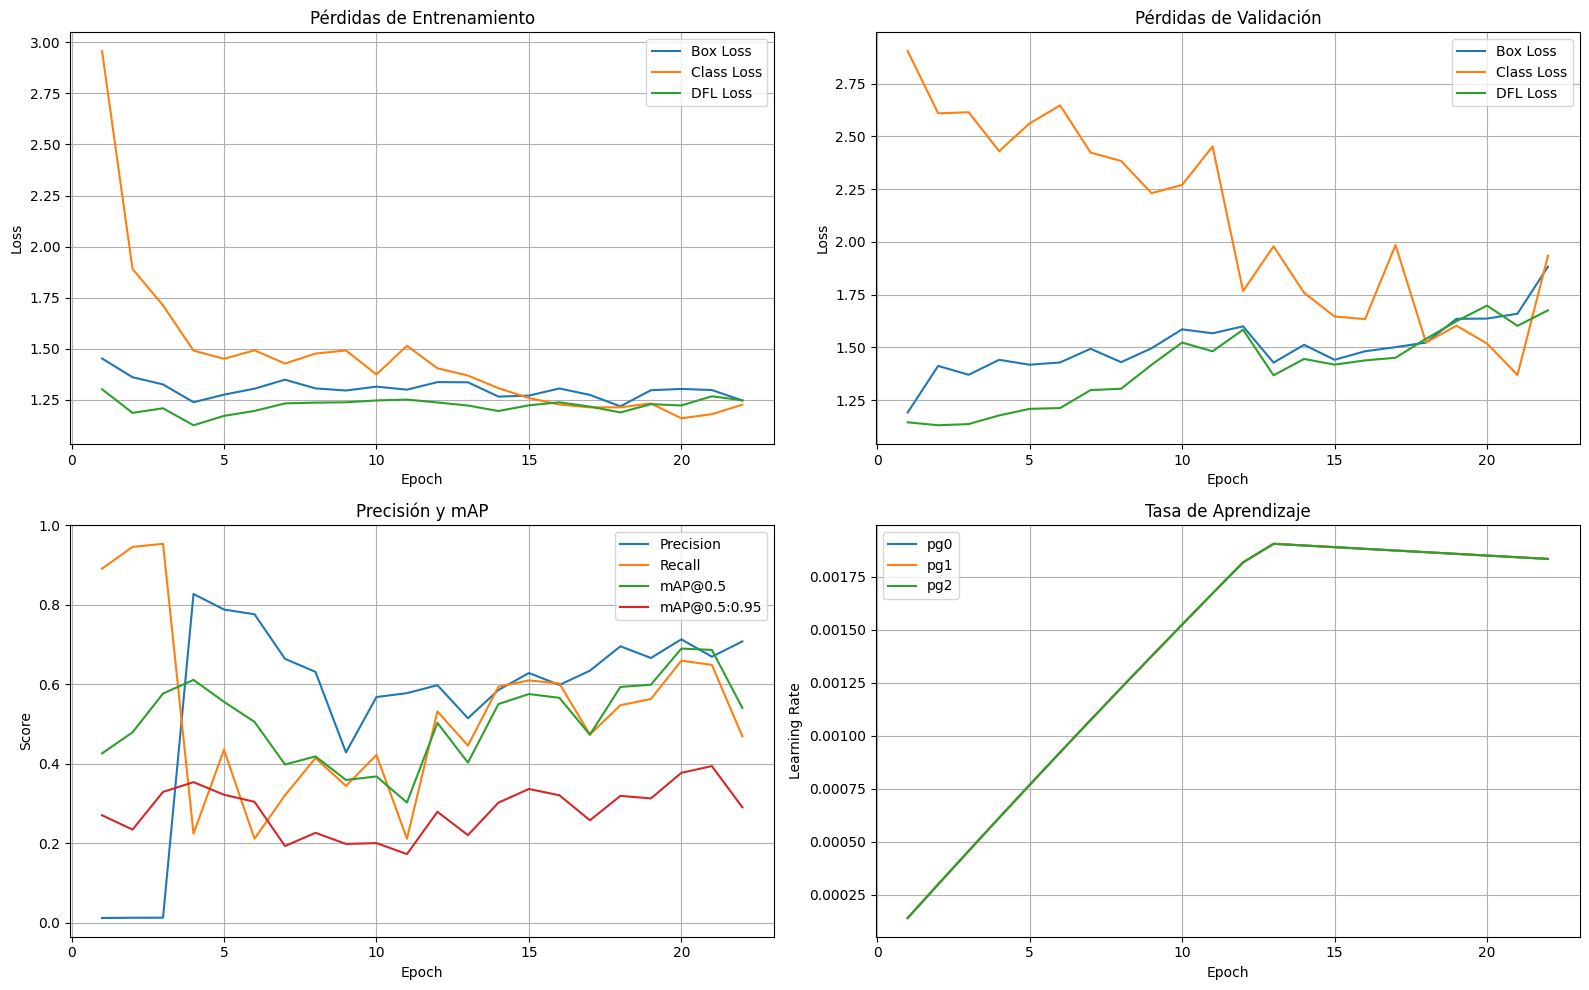

In [29]:
plt.figure(figsize=(16, 10))

# Entrenamiento
plt.subplot(2, 2, 1)
plt.plot(df['epoch'], df['train_box_loss'], label='Box Loss')
plt.plot(df['epoch'], df['train_cls_loss'], label='Class Loss')
plt.plot(df['epoch'], df['train_dfl_loss'], label='DFL Loss')
plt.title("Pérdidas de Entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Validación
plt.subplot(2, 2, 2)
plt.plot(df['epoch'], df['val_box_loss'], label='Box Loss')
plt.plot(df['epoch'], df['val_cls_loss'], label='Class Loss')
plt.plot(df['epoch'], df['val_dfl_loss'], label='DFL Loss')
plt.title("Pérdidas de Validación")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Precisión y mAP
plt.subplot(2, 2, 3)
plt.plot(df['epoch'], df['precision'], label='Precision')
plt.plot(df['epoch'], df['recall'], label='Recall')
plt.plot(df['epoch'], df['mAP50'], label='mAP@0.5')
plt.plot(df['epoch'], df['mAP50_95'], label='mAP@0.5:0.95')
plt.title("Precisión y mAP")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True)
plt.legend()

# Learning Rate
plt.subplot(2, 2, 4)
plt.plot(df['epoch'], df['lr0'], label='pg0')
plt.plot(df['epoch'], df['lr1'], label='pg1')
plt.plot(df['epoch'], df['lr2'], label='pg2')
plt.title("Tasa de Aprendizaje")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("resumen_entrenamiento.png", dpi=300)
plt.show()

In [ ]:
plt.savefig("EntrenamientoDeYololo20epochs.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>